In [1]:
%load_ext autoreload
%autoreload 2

import os, sys, shutil, bz2, warnings
from pathlib import Path
from natsort import natsorted
import pandas as pd
pd.set_option('display.max_columns', 50)
import numpy as np
from numpy.random import Generator, PCG64
rng_pg = Generator(PCG64())
from scipy.optimize import newton, minimize, fsolve
from scipy.optimize import nnls
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from Bio import SeqIO

### Plotting imports ###
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib as mpl
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
palette = list(mcolors.TABLEAU_COLORS.keys())
sns.set_theme(style="ticks", palette="muted")
sns.set_context("notebook")
%matplotlib inline

from wand.image import Image as WImage

In [2]:
# Navigate back to NBdir in case of re-running a code block:
if not 'NBdir' in globals():
    NBdir = os.getcwd()
print('Notebook is in: {}'.format(NBdir))
os.chdir(NBdir)  # If you changed the current working dir, this will take you back to the notebook dir.

# Define the path to the repo folder.
# Change if necessary.
homedir = '/'.join(NBdir.split('/')[0:-2])
print('Repo is in: {}'.format(homedir))
sys.path.insert(1, homedir)
from src.stats_collection import STATS_collection
from src.plotting import TRNA_plot
from src.curve_fitting import loss_func_c1, loss_func_l1, loss_func_l2, hl_bsl_fit, bootstrap_hl, bootstrap_hl_fast, hl2_bsl_fit, obj_hl2_bsl_fit, hl_ccF_bsl_fit, obj_hl_ccF_bsl_fit
from src.misc import moving_average, moving_std, find_nearest

# These are default folder names for data and raw fastq files
# relative to the folder in which this notebook is in:
data_dir = 'data'
stats_dir = 'stats_collection'
plotting_dir = 'plotting_pub'

Notebook is in: /Users/krdav/Google Drive/MCB/Sullivan_lab/tRNA-charge-seq/projects/charge_half-life
Repo is in: /Users/krdav/Google Drive/MCB/Sullivan_lab/tRNA-charge-seq


# Determining aminoacylation half-life using tRNA-charge sequencing
This notebook is a copy of `infer_hl.ipynb` for making plots more suitable for publication.
Explanatory text is largely omitted, see `infer_hl.ipynb` for details.

### Read and filter input data

In [3]:
sample_list_fnam = 'sample_list.xlsx'
sample_df = pd.read_excel('{}/{}'.format(NBdir, sample_list_fnam))
# Isolate the half-life samples:
mask = (sample_df['plot_group'] == 'Acylation-half-life')
sample_df = sample_df[mask].reset_index(drop=True).copy()
sample_df['run_v1'] = np.array([fn[0:10] == '2022-12-28' for fn in sample_df['fastq_mate1_filename']])

# Make a dictionary with paths used for data processing:
dir_dict = dict(NBdir = NBdir,
                data_dir = data_dir,
                stats_dir = stats_dir,
                plotting_dir = plotting_dir)

# Get charge dataframe for aggregated stats:
plot_obj = TRNA_plot(dir_dict, sample_df=sample_df, \
                     stats_fnam='ALL_stats_aggregate.csv', \
                     overwrite_dir=False)

Folder exists and overwrite set to false... Doing nothing.


In [4]:
# Add E.coli control RPM to sample level information:
ecoliLys_mask = (plot_obj.charge_filt['tr']['tRNA_anno_short'] == 'eColiLys-TTT-1-1')
ectr = plot_obj.charge_filt['tr'][ecoliLys_mask].copy()
sample_df = ectr.loc[:, ['sample_name_unique', 'RPM']].merge(sample_df, on='sample_name_unique')
sample_df = sample_df.rename(columns={'RPM': 'RPM_Ectr'}, errors='ignore')

# Extract dataframe with charge and add sample information:
charge_df = sample_df.loc[:, ['sample_name_unique', 'hue_value', 'hue_order', 'RPM_Ectr', 'run_v1']].merge(plot_obj.charge_filt['tr'], on='sample_name_unique')

# Convert time to minutes:
time_list = list()
ox_list = list()
for sn in charge_df['sample_name']:
    if 'NoOx' in sn:
        time_list.append(40*60)
        ox_list.append(False)
    elif 'm' in sn:
        time_list.append(int(sn[:-1]))
        ox_list.append(True)
    elif 'h' in sn:
        time_list.append(int(sn[:-1])*60)
        ox_list.append(True)
    else:
        raise Exception('???')
charge_df['Time'] = time_list
charge_df['Ox'] = ox_list
charge_df['tRNA_anno_short'] = ['mito-'+an if mc else an for an, mc in zip(charge_df['tRNA_anno_short'], charge_df['mito_codon'])]
charge_df['xticklab'] = [str(t) if ox else str(t)+' NoOx' for t, ox in zip(charge_df['Time'], charge_df['Ox'])]

In [5]:
# Enforce minimum UMI count:
min_count = 700
# For each tRNA annotation, find samples
# that have above the minimum count:
tann2snu = dict()
for snu, tann, ectr, cnt in zip(charge_df['sample_name_unique'], \
                                charge_df['tRNA_annotation'], \
                                charge_df['Ecoli_ctr'], \
                                charge_df['UMIcount']):
    if ectr or cnt <= min_count:
        continue
    
    if tann in tann2snu:
        tann2snu[tann].add(snu)
    else:
        tann2snu[tann] = set()
        tann2snu[tann].add(snu)

# Filter tRNA annotation based on
# all samples having above the minimum count:
all_snu = set(charge_df['sample_name_unique'])
tann_sele = set()
for tann in tann2snu:
    if tann2snu[tann] == all_snu:
        tann_sele.add(tann)
mask = charge_df['tRNA_annotation'].isin(tann_sele)
filt_df = charge_df[mask].copy()
filt_df['RPM_norm'] = filt_df['RPM'] / filt_df['RPM_Ectr']

# Create dataframe for each tRNA annotation.
# To this the aminoacylatio half-life will be added later.
hl_df = filt_df.groupby(['tRNA_annotation', 'tRNA_anno_short', \
                         'tRNA_annotation_len', 'codon', 'anticodon', \
                         'AA_codon', 'amino_acid', 'AA_letter', 'mito_codon', \
                         'Ecoli_ctr']).agg(RPMnorm=('RPM_norm', 'mean'), \
                                           RPMmean=('RPM', 'mean'), \
                                           RPMstd=('RPM', 'std'), \
                                           RPMcv=('RPM', lambda x: x.std()/x.mean()*100)).reset_index()

### Check data integrity

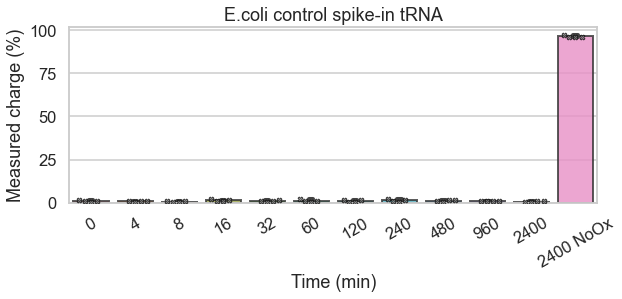

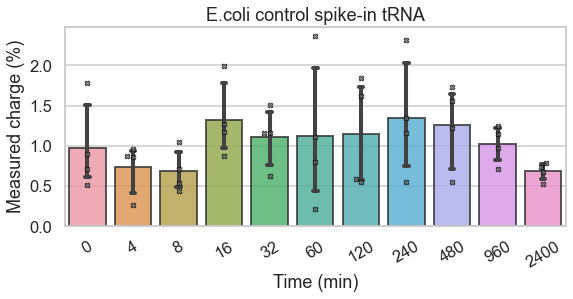

In [6]:
# Select E.coli controls samples:
ectr_mask = (charge_df['tRNA_anno_short'] == 'eColiLys-TTT-1-1')
plot_df = charge_df[ectr_mask].copy()
# Indicator for the non-oxidized sample:
x_order = natsorted(set(plot_df['xticklab']))

# Plot:
with sns.axes_style("whitegrid"):
    fig, ax1 = plt.subplots(1, 1, figsize=(9, 4.5))
    g1 = sns.barplot(ax=ax1, data=plot_df, x='xticklab', y='charge', \
                     capsize=0.1, edgecolor=".2", linewidth=2, alpha=0.8, \
                     order=x_order)
    g1 = sns.swarmplot(ax=ax1, data=plot_df, x='xticklab', y='charge', \
                       color='grey', alpha=0.8, edgecolor='black', linewidth=0.8, \
                       size=5, marker="X", order=x_order)
    g1.set(xlabel='Time (min)', ylabel='Measured charge (%)')
    g1.set_xticklabels(g1.get_xticklabels(), rotation=30)
    g1.set_title('E.coli control spike-in tRNA')
    fig.tight_layout()
    fig.savefig('data/plotting_pub/ecoli-control_charge.pdf', bbox_inches='tight')


# Plot without the non-oxidized sample:
with sns.axes_style("whitegrid"):
    fig, ax1 = plt.subplots(1, 1, figsize=(8.3, 4.5))

    g1 = sns.barplot(ax=ax1, data=plot_df, x='xticklab', y='charge', \
                     capsize=0.1, edgecolor=".2", linewidth=2, alpha=0.8, \
                     order=x_order[:-1])
    g1 = sns.swarmplot(ax=ax1, data=plot_df, x='xticklab', y='charge', \
                       color='grey', alpha=0.8, edgecolor='black', linewidth=0.8, \
                       size=5, marker="X", order=x_order[:-1])
    g1.set(xlabel='Time (min)', ylabel='Measured charge (%)')
    g1.set_xticklabels(g1.get_xticklabels(), rotation=30)
    g1.set_title('E.coli control spike-in tRNA')
    fig.tight_layout()
    fig.savefig('data/plotting_pub/ecoli-control_charge_only-Ox.pdf', bbox_inches='tight')

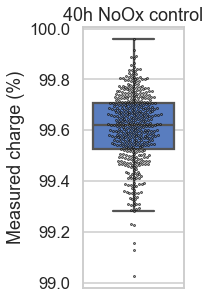

In [7]:
# Plot the charge for the
# non-oxidized control samples:
with sns.axes_style("whitegrid"):
    fig, ax1 = plt.subplots(1, 1, figsize=(3, 4.5))
    noxm = (charge_df['xticklab'] == '2400 NoOx') & (~charge_df['Ecoli_ctr']) & (charge_df['RPM'] > 2000)
    g1 = sns.boxplot(ax=ax1, y=charge_df.loc[noxm, 'charge'].values, fliersize=False)
    g1 = sns.swarmplot(ax=ax1, y=charge_df.loc[noxm, 'charge'].values, \
                       color='grey', alpha=0.7, edgecolor='black', \
                       linewidth=0.8, size=2)
    g1.set(ylabel='Measured charge (%)')
    g1.set_title('40h NoOx control')
    fig.tight_layout()
    fig.savefig('data/plotting_pub/NoOx-control_charge.pdf', bbox_inches='tight')

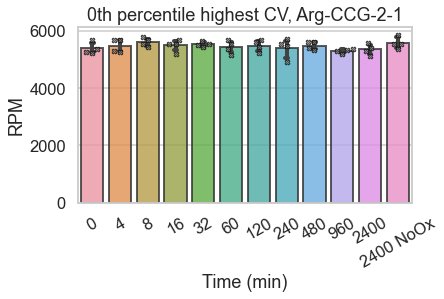

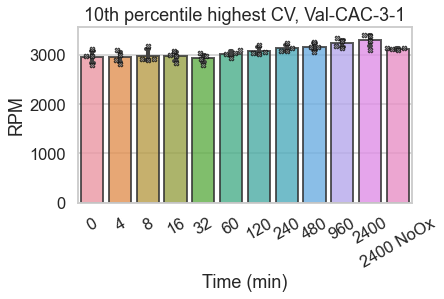

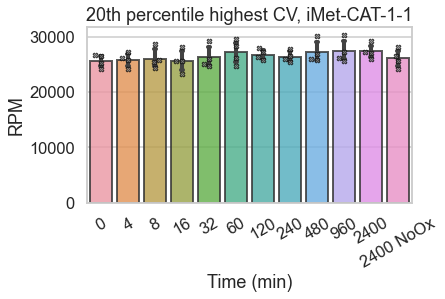

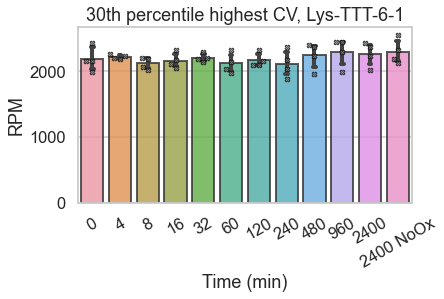

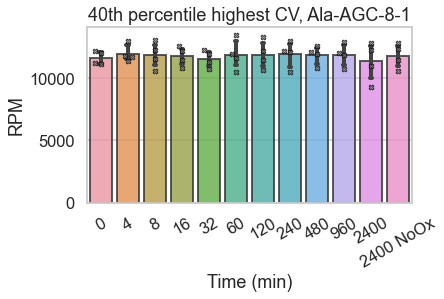

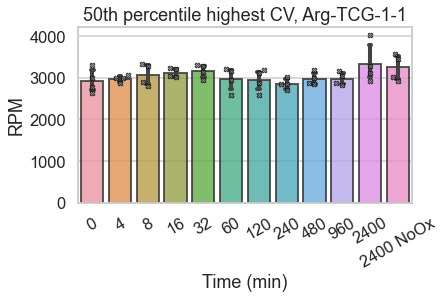

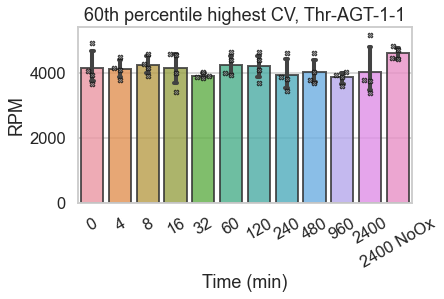

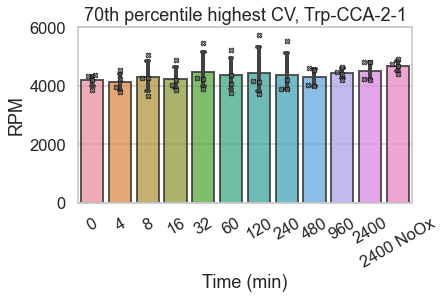

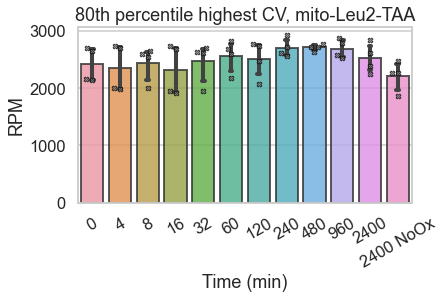

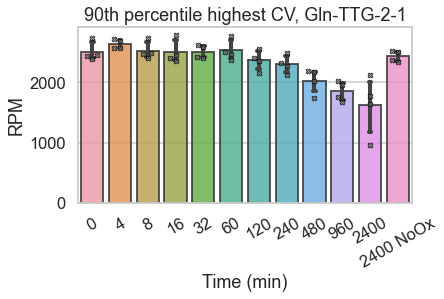

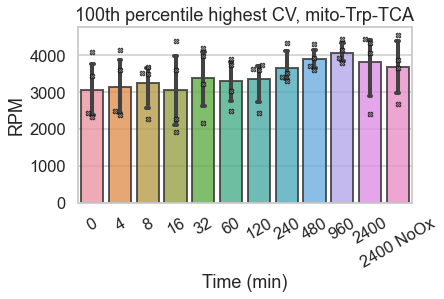

In [8]:
# Require minimum RPM value:
RPM_mask = hl_df['RPMmean'] > 2000
# Pick percentiles:
RPMcv_list = np.percentile(hl_df.loc[RPM_mask, 'RPMcv'], np.linspace(0, 100, 11), method='closest_observation')

# Plot:
prctl = 0
with PdfPages('data/plotting_pub/RPM_variance.pdf') as pp:
    for p_cv in RPMcv_list:
        anno = hl_df.loc[(hl_df['RPMcv'] == p_cv), 'tRNA_anno_short'].values[0]
        anno_mask = filt_df['tRNA_anno_short'] == anno
        bc_order = sorted(set(filt_df['barcode']))
        with sns.axes_style("whitegrid"):
            fig, ax1 = plt.subplots(1, 1, figsize=(6.5, 4.5))
            g1 = sns.barplot(ax=ax1, data=filt_df[anno_mask], x='xticklab', y='RPM', \
                             capsize=0.1, edgecolor=".2", linewidth=2, alpha=0.8, \
                             order=x_order)
            g1 = sns.swarmplot(ax=ax1, data=filt_df[anno_mask], x='xticklab', y='RPM', \
                               color='grey', alpha=0.8, edgecolor='black', linewidth=0.8, \
                               size=5, marker="X", order=x_order, warn_thresh=1)
            g1.set(xlabel='Time (min)', ylabel='RPM')
            g1.set_xticklabels(g1.get_xticklabels(), rotation=30)
            g1.set_title('{}th percentile highest CV, {}'.format(prctl, anno))
            prctl += 10
            fig.tight_layout()
            pp.savefig(fig, bbox_inches='tight')

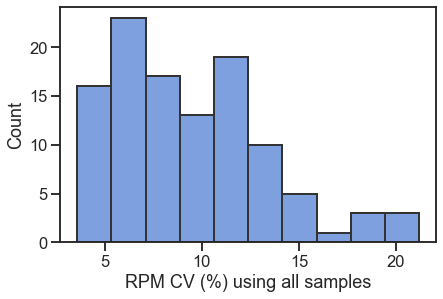

In [9]:
fig, ax1 = plt.subplots(1, 1, figsize=(6.5, 4.5))
g1 = sns.histplot(data=hl_df[RPM_mask], x='RPMcv', bins=10, \
                  edgecolor=".2", linewidth=2, alpha=0.7,)
g1.set(xlabel='RPM CV (%) using all samples', ylabel='Count')

fig.tight_layout()
fig.savefig('data/plotting_pub/RPM_CV_histogram.pdf', bbox_inches='tight')

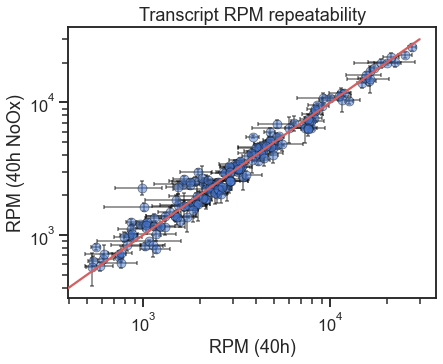

In [10]:
# Select oxidized and non-oxidized samples:
oxm = (filt_df['xticklab'] == '2400') & (~filt_df['Ecoli_ctr'])
noxm = (filt_df['xticklab'] == '2400 NoOx') & (~filt_df['Ecoli_ctr'])
rpm_cols = ['tRNA_anno_short', 'RPM']

# Aggregate to get the mean and standard deviation
# over the four replicates:
oxdf = filt_df.loc[oxm, rpm_cols].groupby('tRNA_anno_short').agg(RPMmean=('RPM', 'mean'), \
                                                                 RPMstd=('RPM', 'std')).reset_index()
noxdf = filt_df.loc[noxm, rpm_cols].groupby('tRNA_anno_short').agg(RPMmean=('RPM', 'mean'), \
                                                                   RPMstd=('RPM', 'std')).reset_index()
# Merge for plotting:
plot_df = oxdf.merge(noxdf, on='tRNA_anno_short', suffixes=('_40h', '_40h_NoOx'))

# Plot the RPM repeatability per transcript
# comparing oxidized vs. non-oxidized samples:
fig, ax1 = plt.subplots(1, 1, figsize=(6.5, 5.4))
g1 = sns.scatterplot(ax=ax1, data=plot_df, x='RPMmean_40h', y='RPMmean_40h_NoOx', \
                     zorder=5, alpha=0.5, \
                     edgecolor='black', linewidth=0.7, legend=False)
g1.set_title('Transcript RPM repeatability')
g1.set(xlabel='RPM (40h)', ylabel='RPM (40h NoOx)')
g1.set_yscale('log', base=10)
g1.set_xscale('log', base=10)
ax1.errorbar(plot_df['RPMmean_40h'].values, plot_df['RPMmean_40h_NoOx'].values, xerr=plot_df['RPMstd_40h'].values, yerr=plot_df['RPMstd_40h_NoOx'].values, fmt='none', capsize=2, zorder=1, \
             ecolor='black', elinewidth=2, capthick=2, alpha=0.4)
ax1.plot([0, 30000], [0, 30000], c='r', zorder=10)
fig.tight_layout()
fig.savefig('data/plotting_pub/RPM_repeatability.pdf', bbox_inches='tight')

In [11]:
# Function to plot the time-series
# charge data along with the fitted half-life function:
def plot_hl(df, p_est, ci, plot_return=True, plot_fh=None):
    fig = plt.figure(figsize=(15, 9))
    gs = fig.add_gridspec(2, 6)
    ax1 = fig.add_subplot(gs[0, 0:2])
    ax2 = fig.add_subplot(gs[0, 2:4])
    ax3 = fig.add_subplot(gs[0, 4:6])
    ax4 = fig.add_subplot(gs[1, 1:3])
    ax5 = fig.add_subplot(gs[1, 3:5])
    
    # Half-life fit and confidence interval:
    fit_x = np.linspace(df['Time'].min(), df['Time'].max(), 1000)
    fit_y = hl_bsl_fit(fit_x, *p_est)
    fit_yb = hl_bsl_fit(fit_x, *ci[0])
    fit_yt = hl_bsl_fit(fit_x, *ci[1])

    # No transformation:
    g1 = sns.scatterplot(ax=ax1, data=df, x='Time', y='charge', style='replicate', \
                         markers=True, zorder=10, alpha=0.5, \
                         edgecolor='black', linewidth=0.7, legend=False)
    g1.set_title('No transform')
    g1.set(xlabel='Time (min)', ylabel='Charge (%)')
    ax1.plot(fit_x, fit_yb, c='g', ls='--', zorder=1)
    ax1.plot(fit_x, fit_yt, c='g', ls='--', zorder=2)
    ax1.plot(fit_x, fit_y, c='r', zorder=3)

    # Log transformed y-axis:
    g2 = sns.scatterplot(ax=ax2, data=df, x='Time', y='charge', style='replicate', \
                         markers=True,  zorder=10, alpha=0.5, \
                         edgecolor='black', linewidth=0.7, legend=False)
    g2.set_title('Log2 y')
    g2.set(xlabel='Time (min)', ylabel='Charge (%)')
    g2.set_yscale('log', base=2)
    ax2.plot(fit_x, fit_yb, c='g', ls='--', zorder=1)
    ax2.plot(fit_x, fit_yt, c='g', ls='--', zorder=2)
    ax2.plot(fit_x, fit_y, c='r', zorder=3)

    # # Log transformed x-axis:
    df['Time+1'] = df['Time'] + (df['Time'] == 0) * 1
    g3 = sns.scatterplot(ax=ax3, data=df, x='Time+1', y='charge', style='replicate', \
                         markers=True,  zorder=10, alpha=0.5, \
                         edgecolor='black', linewidth=0.7, legend=True)
    g3.set(xlabel='Time (min)', ylabel='Charge (%)')
    g3.set_title('Log2 x')
    g3.set_xscale('log', base=2)
    ax3.plot(fit_x, fit_yb, c='g', ls='--', zorder=1)
    ax3.plot(fit_x, fit_yt, c='g', ls='--', zorder=2)
    ax3.plot(fit_x, fit_y, c='r', zorder=3)
    sns.move_legend(g3, "upper left", bbox_to_anchor=(1.01, 1.03), ncol=1, title='Replicate')

    # Plot prediction errors with moving mean
    # as a function of time:
    g4 = sns.scatterplot(ax=ax4, data=df, x='Time+1', y='pred_err', style='replicate', \
                         markers=True,  zorder=10, alpha=0.5, \
                         edgecolor='black', linewidth=0.7, legend=False)
    g4.set_xscale('log', base=2)
    # Moving mean:
    chs = df.sort_values(by='Time+1', ascending=False)['Time+1'].values
    prs = df.sort_values(by='Time+1', ascending=False)['pred_err'].values
    ax4.plot(moving_average(chs, n=3), moving_average(prs, n=3), color='r')
    g4.set(xlabel='Time (min)', ylabel='Error (mes - pred; p.p.)')
    g4.set_title('Prediction error')

    
    # Plot prediction errors with moving mean
    # as a function of measured charge:
    g5 = sns.scatterplot(ax=ax5, data=df, x='charge', y='pred_err', style='replicate', \
                         markers=True,  zorder=10, alpha=0.5, \
                         edgecolor='black', linewidth=0.7, legend=False)
    # Moving mean:
    chs = df.sort_values(by='charge', ascending=False)['charge'].values
    prs = df.sort_values(by='charge', ascending=False)['pred_err'].values
    ax5.plot(moving_average(chs, n=3), moving_average(prs, n=3), color='r')
    g5.set(xlabel='Charge (%)', ylabel='Error (mes - pred; p.p.)')
    g5.set_title('Prediction error')


    tRNA_name = df['tRNA_anno_short'].values[0]
    fig.suptitle('{} half-life={:.0f} min, 95% CI ({:.0f}; {:.0f})'.format(tRNA_name, p_est[1], ci[0][1], ci[1][1]), size=16);
    fig.tight_layout()
    
    if not plot_fh is None:
        plot_fh.savefig(fig, bbox_inches='tight')
    else:
        fig.savefig('data/plotting_pub/{}.pdf'.format(tRNA_name), bbox_inches='tight')
    if plot_return is False:
        plt.close(fig)


In [12]:
# Run analysis on half-life data
# one tRNA transcript at the time:
res = list()
pred_list = list()
index_list = list()
with PdfPages('data/plotting_pub/hl-fit.pdf') as pp:
    for tann in hl_df['tRNA_annotation']:
        # Extract dataframe with single tRNA annotation:
        sample_mask = (filt_df['tRNA_annotation'] == tann) & (filt_df['Ox'])
        hl_spl = filt_df[sample_mask].copy()
        # Infer half-life point estimate and 
        # bootstrap the confidence interval:
        residual, p_est, ci = bootstrap_hl(hl_spl, Ndraws=1000, BFGS_loss_func=loss_func_l2, lstsq=False)
        pred = hl_bsl_fit(hl_spl['Time'].values, *p_est)
        pred_list.extend(pred)
        index_list.extend(hl_spl.index.values)

        # Plot the fit:
        aa = hl_spl['tRNA_anno_short'].values[0].split('-')[0]
        hl_spl['pred_err'] = hl_spl['charge'] - pred
        plot_hl(hl_spl, p_est, ci, plot_fh=pp, plot_return=False)
        # Store results:
        res.append([residual, p_est[1], \
                    ci[0][1], ci[1][1], (p_est, ci)])

# Add results to dataframe:
hl_df['hl_residual'] = [row[0] for row in res] # these are taken on the mean replicate charge
hl_df['hl_p_est'] = [row[1] for row in res]
hl_df['res_ci_l'] = [row[2] for row in res]
hl_df['res_ci_u'] = [row[3] for row in res]
hl_df['res_param'] = [row[4] for row in res]

# Add results to sample level information:
filt_df['charge_pred'] = np.nan
filt_df.loc[index_list, 'charge_pred'] = pred_list
filt_df['pred_err'] = filt_df['charge'] - filt_df['charge_pred']

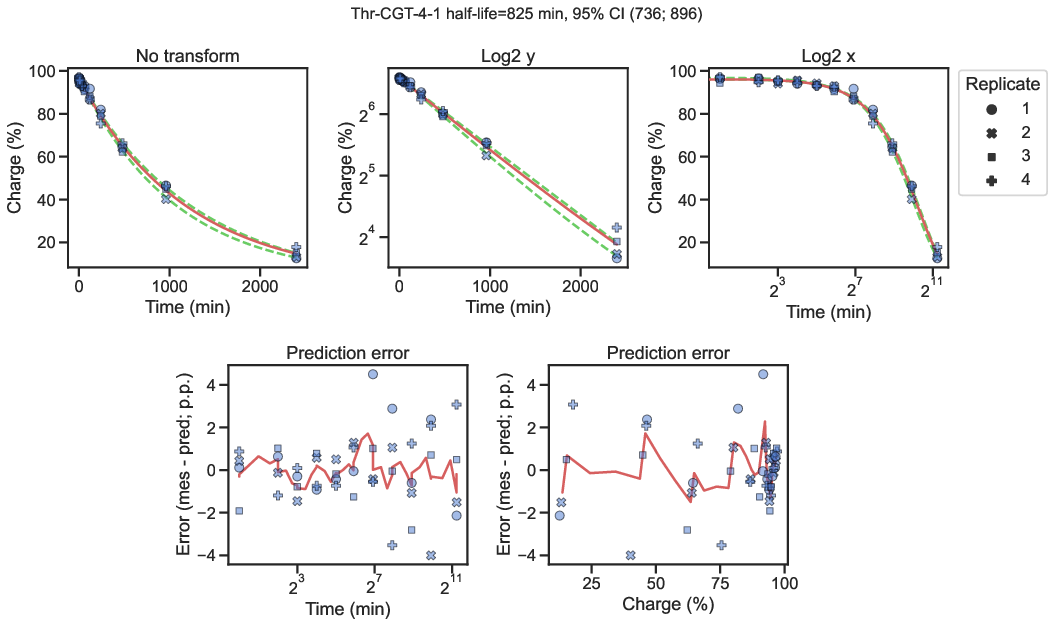

In [13]:
random_image = np.random.randint(len(hl_df['tRNA_annotation']))
img = WImage(filename='data/plotting_pub/hl-fit.pdf[{}]'.format(random_image))
img

In [14]:
hl_df.sort_values(by='hl_residual', ascending=False).reset_index().loc[0:30, ['tRNA_anno_short', 'hl_residual']].head(20)

,tRNA_anno_short,hl_residual
0,mito-Met-CAT,114.717928
1,SeC-TCA-1-1,58.430144
2,Gln-TTG-1-1,28.091931
3,Gln-TTG-2-1,28.085798
4,Cys-GCA-8-1,18.418399
5,Cys-GCA-9-1,16.308955
6,Gln-TTG-3-1,14.632846
7,Gln-CTG-2-1,14.315826
8,mito-Tyr-GTA,14.270360
9,Cys-GCA-4-1,13.669669


In [15]:
# Function to test the two-species model:
def test_two_species(inp_df, short_anno):
    sample_mask = (inp_df['tRNA_anno_short'] == short_anno) & (inp_df['Ox'])
    df = inp_df[sample_mask].copy()
    ch_dat = dict()
    for t, ch in zip(df['Time'], df['charge']):
        if t in ch_dat:
            ch_dat[t].append(ch)
        else:
            ch_dat[t] = list()
            ch_dat[t].append(ch)

    time_arr = np.array(list(ch_dat.keys()))
    mean = np.zeros(len(ch_dat))

    # Allow two species:
    bnds = ((0, 100), (0, 100), (1, 1e5), (1, 1e5), (0, 3.5))
    guess = (90, 10, 3000, 30, 1)
    for i, t in enumerate(time_arr):
        mean[i] = np.mean(ch_dat[t])
    def fun_hl2_bsl(p): return(obj_hl2_bsl_fit(loss_func_l2, mean, time_arr, p))
    p_hl_bsl = minimize(fun_hl2_bsl, guess, method='L-BFGS-B', bounds=bnds)
    
    return((p_hl_bsl.fun, p_hl_bsl.x))


In [16]:
# Function to plot the comparison between
# a one and a two species model:
def compare_one_two(df, p1, p2, plot_return=True):
    fig = plt.figure(figsize=(16, 5))
    gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 1])
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[0, 2])

    # Half-life fit and confidence interval:
    fit_x = np.linspace(df['Time'].min(), df['Time'].max(), 1000)
    fit_y1 = hl_bsl_fit(fit_x, *p1)
    fit_y2 = hl2_bsl_fit(fit_x, *p2)

    # No transformation:
    g1 = sns.scatterplot(ax=ax1, data=df, x='Time', y='charge', style='replicate', \
                         markers=True, zorder=10, alpha=0.5, \
                         edgecolor='black', linewidth=0.7, legend=False)
    g1.set_title('No transform')
    g1.set(xlabel='Time (min)', ylabel='Charge (%)')
    ax1.plot(fit_x, fit_y1, c='g', zorder=2)
    ax1.plot(fit_x, fit_y2, c='r', zorder=3)

    # Log transformed y-axis:
    g2 = sns.scatterplot(ax=ax2, data=df, x='Time', y='charge', style='replicate', \
                         markers=True,  zorder=10, alpha=0.5, \
                         edgecolor='black', linewidth=0.7, legend=False)
    g2.set_title('Log2 y')
    g2.set(xlabel='Time (min)', ylabel='Charge (%)')
    g2.set_yscale('log', base=2)
    ax2.plot(fit_x, fit_y1, c='g', zorder=2)
    ax2.plot(fit_x, fit_y2, c='r', zorder=3)

    # # Log transformed x-axis:
    df['Time+1'] = df['Time'] + (df['Time'] == 0) * 1
    g3 = sns.scatterplot(ax=ax3, data=df, x='Time+1', y='charge', style='replicate', \
                         markers=True,  zorder=10, alpha=0.5, \
                         edgecolor='black', linewidth=0.7)
    g3.set(xlabel='Time (min)', ylabel='Charge (%)')
    g3.set_title('Log2 x')
    g3.set_xscale('log', base=2)
    sns.move_legend(g3, "upper left", bbox_to_anchor=(1.01, 1.03), ncol=1, title='Replicate')
    ax3.plot(fit_x, fit_y1, c='g', zorder=2)
    ax3.plot(fit_x, fit_y2, c='r', zorder=3)

    tRNA_name = df['tRNA_anno_short'].values[0]
    fig.suptitle('{}, two-species at [{:.0f}, {:.0f}] percentage point initial charge, half-life=[{:.0f}, {:.0f}] min'.format(tRNA_name, *p2), size=16);
    fig.tight_layout()
    fig.savefig('data/plotting_pub/{}_two-species_model.pdf'.format(tRNA_name), bbox_inches='tight')
    if plot_return is False:
        plt.close(fig)

In [17]:
# Fit a two species model to each transcript
# and see how this affects the residuals:
two_fit = [test_two_species(filt_df, ta) for ta in hl_df['tRNA_anno_short']]
hl_df['two_fit_residual'] = [tf[0] for tf in two_fit]
hl_df['two_fit_params'] = [tf[1] for tf in two_fit]
hl_df['one-two_resi'] = hl_df['hl_residual'] / hl_df['two_fit_residual']
hl_df.sort_values(by='one-two_resi', ascending=False).loc[:, ['tRNA_anno_short', 'hl_residual', 'one-two_resi']].head(8)

,tRNA_anno_short,hl_residual,one-two_resi
127,SeC-TCA-1-1,58.430144,105.599722
13,mito-Met-CAT,114.717928,72.199837
93,Ile-TAT-2-1,1.614933,14.446149
92,Ile-TAT-1-1,3.377100,6.345140
159,Val-AAC-1-1,2.584274,5.912602
162,Val-CAC-1-1,1.152061,4.544451
163,Val-CAC-2-1,1.170042,3.431222
95,Leu-AAG-2-1,1.897227,2.281967


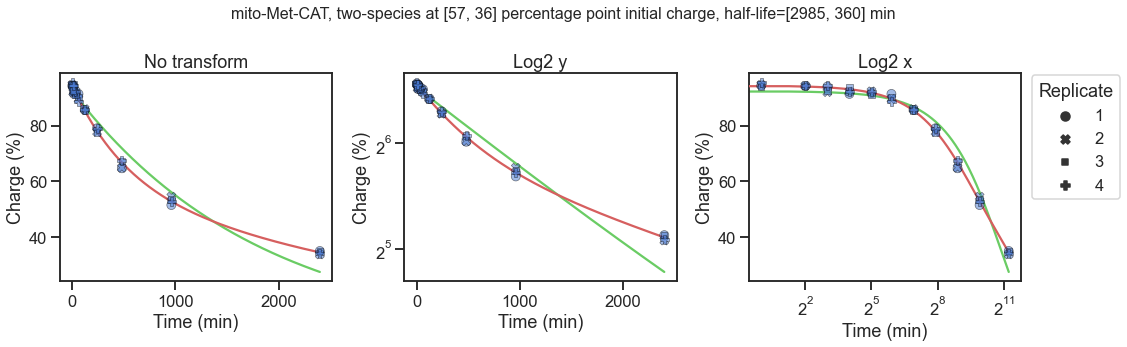

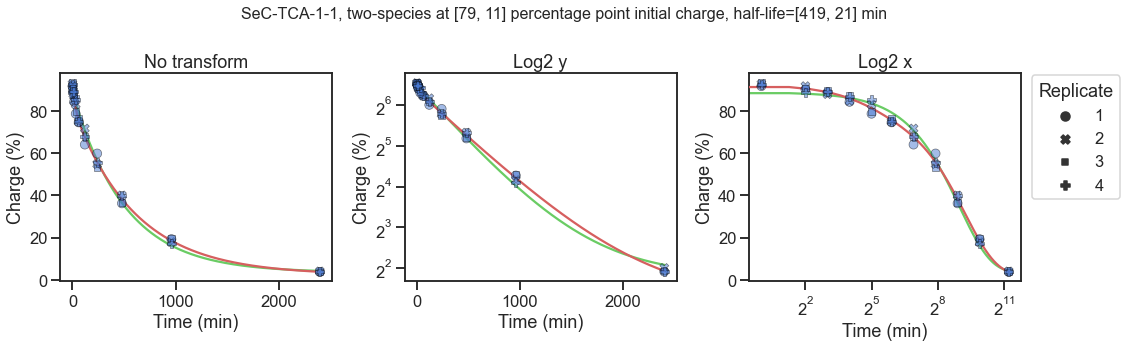

In [18]:
# Plot the comparison betwen one and two species models:
for anno in ['mito-Met-CAT', 'SeC-TCA-1-1']:
    sample_mask = (filt_df['tRNA_anno_short'] == anno) & (filt_df['Ox'])
    hl_spl = filt_df[sample_mask].copy()
    hl_anno_mask = hl_df['tRNA_anno_short'] == anno
    p1 = hl_df.loc[hl_anno_mask, 'res_param'].values[0][0]
    p2 = hl_df.loc[hl_anno_mask, 'two_fit_params'].values[0]
    compare_one_two(hl_spl, p1, p2)

In [19]:
# Write half-life results to .csv file:
hl_df['N0'] = [rp[0][0] for rp in hl_df['res_param']]
hl_df['hl'] = [rp[0][1] for rp in hl_df['res_param']]
hl_df['Ninf'] = [rp[0][2] for rp in hl_df['res_param']]

pcols = ['tRNA_annotation', 'tRNA_annotation_len', 'codon', 'amino_acid', 'mito_codon', \
         'hl', 'res_ci_l', 'res_ci_u', 'N0', 'Ninf', 'hl_residual']
prows = (hl_df['one-two_resi'] < 30)
one_species_tab = hl_df.loc[prows, pcols].rename(columns={'res_ci_l': 'hl_ci_l', 'res_ci_u': 'hl_ci_u'})
one_species_tab.to_csv('acylation_half-lifes.csv', index=False)


hl_df['NA0'] = [rp[0] for rp in hl_df['two_fit_params']]
hl_df['NB0'] = [rp[1] for rp in hl_df['two_fit_params']]
hl_df['hlA'] = [rp[2] for rp in hl_df['two_fit_params']]
hl_df['hlB'] = [rp[3] for rp in hl_df['two_fit_params']]
hl_df['Ninf'] = [rp[4] for rp in hl_df['two_fit_params']]

pcols = ['tRNA_annotation', 'tRNA_annotation_len', 'codon', 'amino_acid', 'mito_codon', \
         'NA0', 'NB0', 'hlA', 'hlB', 'Ninf', 'two_fit_residual']
prows = (hl_df['one-two_resi'] > 30)
two_species_tab = hl_df.loc[prows, pcols].copy()
two_species_tab.to_csv('acylation_half-lifes_two-species.csv', index=False)

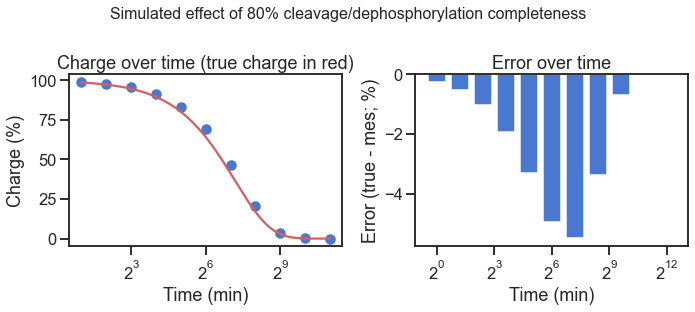

In [20]:
# Generate data:
ccF = 0.8 # fraction of complete cleavage/dephosphorylation
hl = 100  # half-life
hl_true = hl
N0 = 100  # charge at t=0
time_list = np.logspace(1, 11, 11, base=2)
true_charge = N0 * (1/2)**(time_list/hl)

# Find measured charge,
# given incomplete cleavage/dephosphorylation:
ch_list = list()
for t in time_list:
    cca = N0 * (1/2)**(t/hl)
    cc = N0 - cca
    cc *= ccF
    ch = cca/(cc+cca) * 100
    ch_list.append(ch)
ch_list = np.array(ch_list)

# Plot results:
fig = plt.figure(figsize=(10, 4.5))
gs = fig.add_gridspec(1, 2, width_ratios=[1, 1])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

ax1.scatter(time_list, ch_list)
x = np.logspace(1, 11, 1000, base=2)
y = N0 * (1/2)**(x/hl)
ax1.plot(x, y, color='r');
ax1.set_xscale('log', base=2)
ax1.set_title('Charge over time (true charge in red)')
ax1.set_xlabel('Time (min)')
ax1.set_ylabel('Charge (%)')

true_charge = N0 * (1/2)**(time_list/hl)
ax2.bar(np.arange(len(ch_list)), (true_charge - ch_list))
ax2.set_title('Error over time')
ax2.set_xlabel('Time (min)')
ax2.set_ylabel('Error (true - mes; %)')
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ax2.set_xticklabels(ax1.get_xticklabels());

fig.suptitle('Simulated effect of 80% cleavage/dephosphorylation completeness', size=16);
fig.tight_layout()

Half-life true: 100.00
Half-life predicted: 115.61


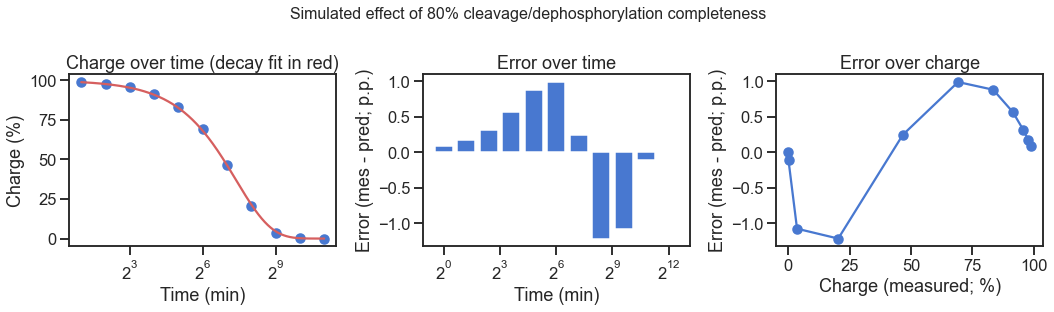

In [21]:
# Half-life function fit with baseline:
def hl_bsl_fit(t, N0, hl, Ninf):
    return(N0*(1/2)**(t/hl)+Ninf)
def obj_hl_bsl_fit(loss_func, mes, t, p):
    N0 = p[0]
    hl = p[1]
    Ninf = p[2]
    y = hl_bsl_fit(t, N0, hl, Ninf)
    loss = sum(loss_func(mes, y))
    return(loss)

# Set baseline to zero with bounds:
bnds = ((0, 100), (1, 1e5), (0, 0.001))
guess = (100, 500, 1)
def fun_hl_bsl(p): return(obj_hl_bsl_fit(loss_func_l2, ch_list, time_list, p))
p_hl_bsl = minimize(fun_hl_bsl, guess, method='L-BFGS-B', bounds=bnds)
N0 = p_hl_bsl.x[0]
hl = p_hl_bsl.x[1]
residual = p_hl_bsl.fun

# Plot results:
fig = plt.figure(figsize=(15, 4.5))
gs = fig.add_gridspec(1, 3)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])

ax1.scatter(time_list, ch_list)
x = np.logspace(1, 11, 1000, base=2)
y = N0 * (1/2)**(x/hl)
ax1.plot(x, y, color='r');
ax1.set_xscale('log', base=2)
ax1.set_title('Charge over time (decay fit in red)')
ax1.set_xlabel('Time (min)')
ax1.set_ylabel('Charge (%)')

pred_charge = N0 * (1/2)**(time_list/hl)
ax2.bar(np.arange(len(ch_list)), (ch_list - pred_charge))
ax2.set_title('Error over time')
ax2.set_xlabel('Time (min)')
ax2.set_ylabel('Error (mes - pred; p.p.)')
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ax2.set_xticklabels(ax1.get_xticklabels());

ax3.scatter(ch_list, (ch_list - pred_charge))
ax3.plot(ch_list, (ch_list - pred_charge))
ax3.set_title('Error over charge')
ax3.set_xlabel('Charge (measured; %)')
ax3.set_ylabel('Error (mes - pred; p.p.)')

fig.suptitle('Simulated effect of 80% cleavage/dephosphorylation completeness', size=16);
fig.tight_layout()
print('Half-life true: {:.2f}\nHalf-life predicted: {:.2f}'.format(hl_true, hl))

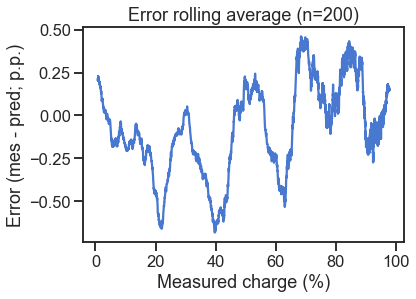

In [22]:
# Plot the prediction error as a function
# of charge to look for patterns:
roll_mask = (~filt_df['pred_err'].isna()) & (~filt_df['tRNA_anno_short'].isin(['SeC-TCA-1-1', 'mito-Met-CAT']))
chs = filt_df[roll_mask].sort_values(by='charge', ascending=False)['charge'].values
prs = filt_df[roll_mask].sort_values(by='charge', ascending=False)['pred_err'].values

fig = plt.figure(figsize=(6, 4.5))
gs = fig.add_gridspec(1, 1)
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(moving_average(chs, n=200), moving_average(prs, n=200))
ax1.set_title('Error rolling average (n=200)')
ax1.set_ylabel('Error (mes - pred; p.p.)')
ax1.set_xlabel('Measured charge (%)')
fig.tight_layout()
fig.savefig('data/plotting_pub/charge_prediction-error_rolling.pdf', bbox_inches='tight')

In [23]:
# Find the standard deviation
# closest to the charge:
def ch_std(ch, ch_rol, err_rol):
    std = list()
    for chi in ch:
        idx = find_nearest(ch_rol, chi)
        std.append(err_rol[idx])
    return(np.array(std))

# Half-life function fit with baseline:
def hl_bsl_fit(t, N0, hl, Ninf):
    return(N0*(1/2)**(t/hl)+Ninf)
def obj_hl_bsl_fit(loss_func, mes, t, p):
    N0 = p[0]
    hl = p[1]
    Ninf = p[2]
    y = hl_bsl_fit(t, N0, hl, Ninf)
    loss = sum(loss_func(mes, y))
    return(loss)

# Simulate the error profile described above
# using the half-lifes inferred:
def simulate_err_profile(hl_df, ccF, ch_rol, err_rol, noise_scale=1, roll_avg=200):
    # Extract half-life data:
    N0_list = [p[0][0] for p in hl_df.loc[:, 'res_param'].values]
    hl_list = [p[0][1] for p in hl_df.loc[:, 'res_param'].values]
    st = np.array(sorted(set(charge_df['Time'])))

    err = list()
    ch_all = list()
    for N0, hl in zip(N0_list, hl_list):
        # Find measured charge,
        # given incomplete cleavage/dephosphorylation:
        ch_list = list()
        for t in time_list:
            cca = N0 * (1/2)**(t/hl)
            cc = N0 - cca
            cc *= ccF
            ch = cca/(cc+cca) * 100
            ch_list.append(ch)
        ch_list = np.array(ch_list)
        # Add random noise from distribution
        # similar to that of real data:
        std_list = ch_std(ch_list, ch_rol, err_rol)
        mes_noise = np.random.normal(loc=0, scale=std_list*noise_scale, size=len(ch_list))
        ch_list += mes_noise
        ch_list[ch_list < 0] = 0
        ch_list[ch_list > 100] = 100

        # Set baseline to zero with bounds:
        bnds = ((0, 100), (1, 1e5), (0, 0.001))
        guess = (100, 500, 1)
        def fun_hl_bsl(p): return(obj_hl_bsl_fit(loss_func_l2, ch_list, time_list, p))
        p_hl_bsl = minimize(fun_hl_bsl, guess, method='L-BFGS-B', bounds=bnds)
        N0 = p_hl_bsl.x[0]
        hl = p_hl_bsl.x[1]
        pred_charge = N0 * (1/2)**(time_list/hl)

        # Find the prediction errors:
        err.extend(list(ch_list - pred_charge))
        ch_all.extend(list(ch_list))

    # Plot prediction error vs measured charge:
    df = pd.DataFrame([ch_all, err]).T.rename(columns={0:'measured_charge', 1: 'pred_err'}).sort_values(by='measured_charge').reset_index(drop=True)

    fig = plt.figure(figsize=(6, 4.5))
    gs = fig.add_gridspec(1, 1)
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(moving_average(df['measured_charge'].values, n=roll_avg), moving_average(df['pred_err'].values, n=roll_avg))
    ax1.set_title('Prediction error profile, ccF={}'.format(ccF))
    ax1.set_ylabel('Error (mes - pred; p.p.)')
    ax1.set_xlabel('Measured charge (%)')
    fig.tight_layout()

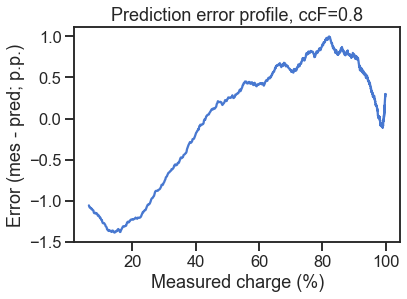

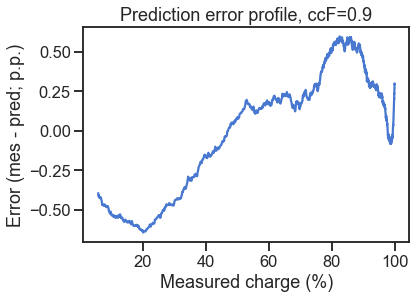

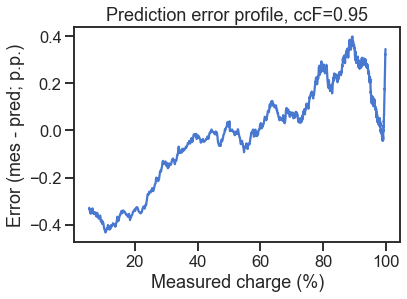

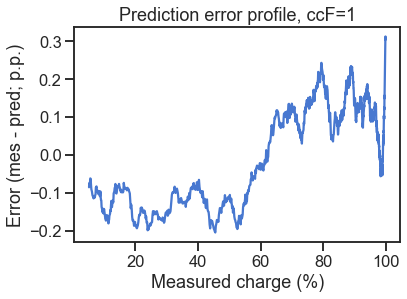

In [24]:
# Use previous prediction errors to find
# the standard deviation used to add noise:
ch_rol = moving_average(chs, n=200)
err_rol = moving_std(prs, n=200)
# Simulate profiles of different ccF:
simulate_err_profile(hl_df, 0.8, ch_rol, err_rol, noise_scale=1, roll_avg=200)
simulate_err_profile(hl_df, 0.9, ch_rol, err_rol, noise_scale=1, roll_avg=200)
simulate_err_profile(hl_df, 0.95, ch_rol, err_rol, noise_scale=1, roll_avg=200)
simulate_err_profile(hl_df, 1, ch_rol, err_rol, noise_scale=1, roll_avg=200)

### Analyzing the prediction errors

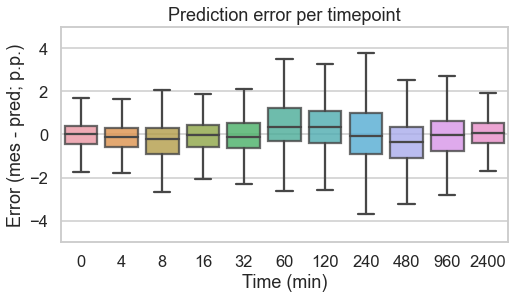

In [25]:
# Prediction error per timepoint:
ox_mask = (filt_df['Ox'])
with sns.axes_style("whitegrid"):
    fig, ax1 = plt.subplots(1, 1, figsize=(7.5, 4.5))
    g1 = sns.boxplot(ax=ax1, data=filt_df[ox_mask], x='Time', y='pred_err', \
                     boxprops=dict(alpha=0.8), fliersize=False)

g1.set(xlabel='Time (min)', ylabel='Error (mes - pred; p.p.)', ylim=(-5, 5))
g1.set_title('Prediction error per timepoint')
fig.tight_layout()
fig.savefig('data/plotting_pub/timepoint_prediction-error.pdf', bbox_inches='tight')

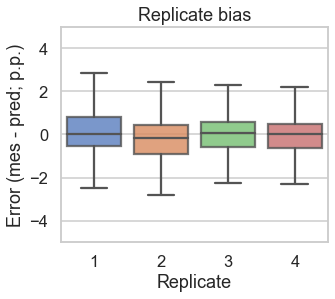

In [26]:
# Replicate bias:
ox_mask = (filt_df['Ox'])
with sns.axes_style("whitegrid"):
    fig, ax1 = plt.subplots(1, 1, figsize=(5, 4.5))
    g1 = sns.boxplot(ax=ax1, data=filt_df[ox_mask], x='replicate', y='pred_err', \
                     boxprops=dict(alpha=0.8), fliersize=False)
g1.set(xlabel='Replicate', ylabel='Error (mes - pred; p.p.)', ylim=(-5, 5))
g1.set_title('Replicate bias')
fig.tight_layout()
fig.savefig('data/plotting_pub/replicate_prediction-error.pdf', bbox_inches='tight')

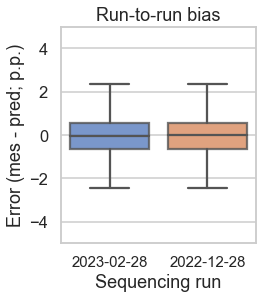

In [27]:
# Run-to-run bias:
ox_mask = (filt_df['Ox'])
with sns.axes_style("whitegrid"):
    fig, ax1 = plt.subplots(1, 1, figsize=(4, 4.5))
    g1 = sns.boxplot(ax=ax1, data=filt_df[ox_mask], x='run_v1', y='pred_err', \
                     boxprops=dict(alpha=0.8), fliersize=False)
g1.set_xticklabels(['2023-02-28', '2022-12-28'], rotation=0, size=15)
g1.set(xlabel='Sequencing run', ylabel='Error (mes - pred; p.p.)', ylim=(-5, 5))
g1.set_title('Run-to-run bias')
fig.tight_layout()
fig.savefig('data/plotting_pub/run-to-run_prediction-error.pdf', bbox_inches='tight')

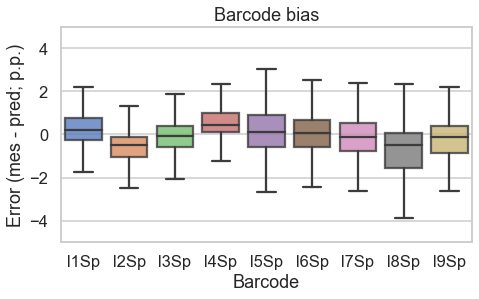

In [28]:
# Barcode bias:
ox_mask = (filt_df['Ox'])
bc_order = sorted(set(filt_df['barcode']))
with sns.axes_style("whitegrid"):
    fig, ax1 = plt.subplots(1, 1, figsize=(7, 4.5))
    g1 = sns.boxplot(ax=ax1, data=filt_df[ox_mask], x='barcode', y='pred_err', \
                     boxprops=dict(alpha=0.8), order=bc_order, fliersize=False)
# g1.set_xticklabels(g1.get_xticklabels(), rotation=30)
g1.set(xlabel='Barcode', ylabel='Error (mes - pred; p.p.)', ylim=(-5, 5))
g1.set_title('Barcode bias')
fig.tight_layout()
fig.savefig('data/plotting_pub/barcode_prediction-error.pdf', bbox_inches='tight')

### Fitting a linear model to find predictors of half-life magnitude


In [29]:
# Add first and discriminator base
# to the dataframe:
tRNA_data = dict()
tRNAdb_fnam = '{}/tRNA_database/human/hg38-tRNAs.fa'.format(homedir)
for record in SeqIO.parse(tRNAdb_fnam, "fasta"):
    tRNA_data[record.id] = dict()
    tRNA_data[record.id]['first_base'] = record.seq[0]
    tRNA_data[record.id]['second_base'] = record.seq[1]
    tRNA_data[record.id]['discr_base'] = record.seq[-4]

base_df = pd.DataFrame.from_dict(tRNA_data).transpose().reset_index().rename(columns={'index': 'tRNA_annotation'})
one_species_tab = one_species_tab.merge(base_df, on='tRNA_annotation', copy=False)
one_species_tab.to_csv('acylation_half-lifes_features.csv', index=False)

In [30]:
# Run OLS:
results = smf.ols('hl ~ amino_acid + tRNA_annotation_len + mito_codon + first_base + discr_base', data=one_species_tab).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                     hl   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     547.1
Date:                Sat, 01 Jul 2023   Prob (F-statistic):          1.59e-127
Time:                        10:34:38   Log-Likelihood:                -933.70
No. Observations:                 167   AIC:                             1925.
Df Residuals:                     138   BIC:                             2016.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             377.0684    

In [31]:
# Select feature with t-statistics less than 0.05,
# then rerun the model:
endog = pd.DataFrame(results.model.endog, columns=[results.model.endog_names])
exog = pd.DataFrame(results.model.exog, columns=results.model.exog_names)
cols_sele = ['Intercept',
             'amino_acid[T.Arg]',
             'amino_acid[T.Asn]',
             'amino_acid[T.Asp]',
             'amino_acid[T.Glu]',
             'amino_acid[T.Gly]',
             'amino_acid[T.Ile]',
             'amino_acid[T.Leu]',
             'amino_acid[T.Pro]',
             'amino_acid[T.Ser]',
             'amino_acid[T.Thr]',
             'amino_acid[T.Trp]',
             'amino_acid[T.Tyr]',
             'amino_acid[T.Val]',
             'first_base[T.C]',
             'discr_base[T.T]']
results = sm.OLS(endog, exog=exog.loc[:, cols_sele]).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                     hl   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     1058.
Date:                Sat, 01 Jul 2023   Prob (F-statistic):          1.31e-144
Time:                        10:34:38   Log-Likelihood:                -938.26
No. Observations:                 167   AIC:                             1909.
Df Residuals:                     151   BIC:                             1958.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           425.4304     11.29

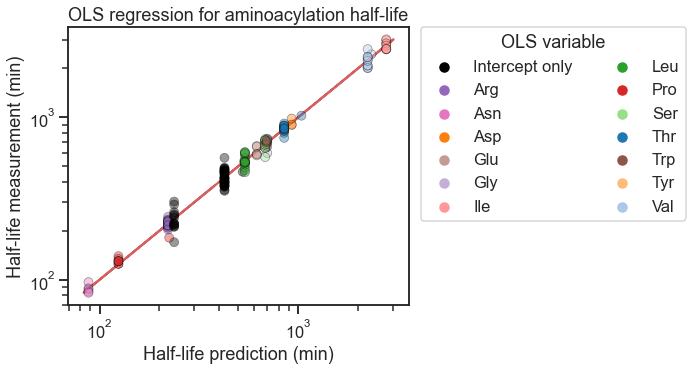

In [32]:
# Plot the regression results:
one_species_tab['hl_pred'] = results.fittedvalues.values
aa_sele = {'Arg', 'Asn', 'Asp', 'Glu', 'Gly', 'Ile', 'Leu', 'Pro', 'Ser', 'Thr', 'Trp', 'Tyr', 'Val'}
AArgb_dict = dict()
cmap_b = mpl.colormaps['tab20']
for aai, aa in enumerate(aa_sele):
    AArgb_dict[aa] = cmap_b(aai)

color_list = list()
aa_sele_list = list()
for aa in one_species_tab['amino_acid']:
    if aa in aa_sele:
        color_list.append(AArgb_dict[aa])
        aa_sele_list.append(aa)
    else:
        color_list.append((0,0,0,1))
        aa_sele_list.append('Intercept only')

one_species_tab['Variable'] = aa_sele_list
sns_palette = {aa:col for aa, col in zip(aa_sele_list, color_list)}

fig, ax1 = plt.subplots(1, 1, figsize=(10, 5.5))
g1 = sns.scatterplot(ax=ax1, data=one_species_tab, x='hl_pred', y='hl', \
                     alpha=0.4, hue='Variable', \
                     edgecolor='black', linewidth=0.7, \
                     palette=sns_palette, \
                     zorder=10)

g1.set_xscale('log', base=10)
g1.set_yscale('log', base=10)
sns.move_legend(g1, "upper left", bbox_to_anchor=(1.01, 1.03), ncol=2, title='OLS variable')
ax1.plot(one_species_tab['hl'], one_species_tab['hl'], \
         color='r', zorder=1)
g1.set(xlabel='Half-life prediction (min)', ylabel='Half-life measurement (min)')
g1.set_title('OLS regression for aminoacylation half-life')
fig.tight_layout()
fig.savefig('data/plotting_pub/half-life_OLS-prediction.pdf', bbox_inches='tight')

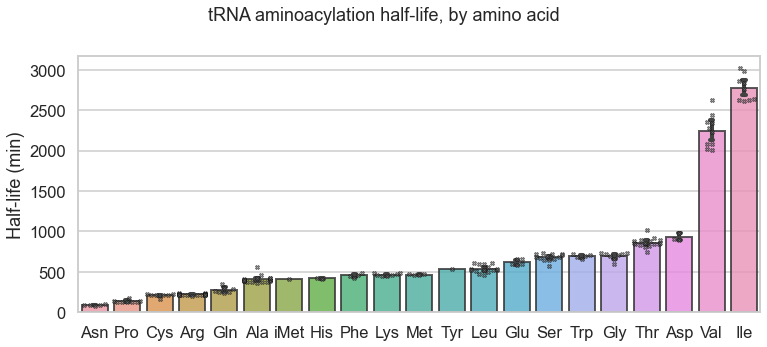

In [33]:
# Plot the amino acid influence on half-life
# in another (maybe simpler) way.

# Sort amino acids according to the mean half-life:
hl_mean_df = one_species_tab.groupby('amino_acid').agg(hl_mean=('hl', 'mean')).reset_index().sort_values(by='hl_mean').reset_index(drop=True)

# Plot half-life "waterfall" plot:
with sns.axes_style("whitegrid"):
    fig, ax1 = plt.subplots(1, 1, figsize=(11, 5))

    g1 = sns.barplot(ax=ax1, data=one_species_tab, x='amino_acid', y='hl', \
                     capsize=0.1, edgecolor=".2", linewidth=2, alpha=0.8, \
                     zorder=1, order=hl_mean_df['amino_acid'])
    g1 = sns.swarmplot(ax=ax1, data=one_species_tab, x='amino_acid', y='hl', dodge=True, \
                       color='grey', alpha=0.6, edgecolor='black', linewidth=0.8, \
                       size=4, marker="X", zorder=2, order=hl_mean_df['amino_acid'], \
                       warn_thresh=1)
    g1.set(ylabel='Half-life (min)', xlabel='')


fig.suptitle('tRNA aminoacylation half-life, by amino acid', size=18)
fig.tight_layout()
fig.savefig('data/plotting_pub/half-life_waterfall.pdf', bbox_inches='tight')

In [34]:
# Compare to Peacock et al.:
hl_mean_std_df = one_species_tab.groupby('amino_acid').agg(mean=('hl', 'mean'), std=('hl', 'std')).reset_index().reset_index(drop=True)

# Data from Peacock et al.:
peacock_mean = {"Pro": 36, "Gln": 93, "Ala": 95, "Cys": 96, "Phe": 127, "Lys": 127, "His": 132, "Tyr": 141, "Leu": 147, "Ser": 202, "Val": 644, "Ile": 810}
peacock_std = {"Pro": 2, "Gln": 7, "Ala": 20, "Cys": 10, "Phe": 5, "Lys": 20, "His": 20, "Tyr": 30, "Leu": 4, "Ser": 10, "Val": 40, "Ile": 30}

df_mpea = pd.DataFrame.from_dict(peacock_mean, orient='index', columns=['mean'])
df_spea = pd.DataFrame.from_dict(peacock_std, orient='index', columns=['std'])
df_pea = df_mpea.merge(df_spea, left_index=True, right_index=True)
df_pea = df_pea.reset_index().rename(columns={'index': 'amino_acid'})

hl_method_comp = hl_mean_std_df.merge(df_pea, on='amino_acid', suffixes=('_tRNAseq', '_Peacock'))
hl_method_comp.head(3)

,amino_acid,mean_tRNAseq,std_tRNAseq,mean_Peacock,std_Peacock
0,Ala,406.382598,44.261057,95,20
1,Cys,210.643769,18.316776,96,10
2,Gln,278.367433,39.761400,93,7


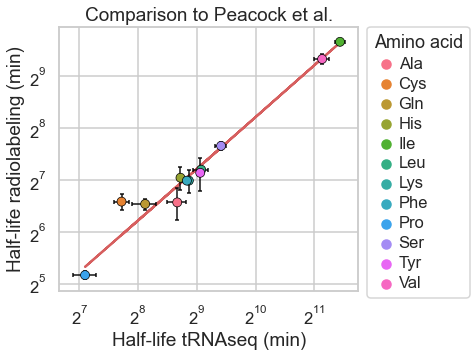

In [35]:
with sns.axes_style("whitegrid"):
    fig, ax1 = plt.subplots(1, 1, figsize=(7, 5.3))
    g1 = sns.scatterplot(ax=ax1, data=hl_method_comp, x='mean_tRNAseq', y='mean_Peacock', \
                         hue='amino_acid',
                         zorder=5, alpha=1, \
                         edgecolor='black', linewidth=0.7)
    g1.set_xlabel('Half-life tRNAseq (min)', size=19)
    g1.set_ylabel('Half-life radiolabeling (min)', size=19)
    g1.set_yscale('log', base=2)
    g1.set_xscale('log', base=2)
    ax1.errorbar(hl_method_comp['mean_tRNAseq'].values, hl_method_comp['mean_Peacock'].values, \
                 xerr=hl_method_comp['std_tRNAseq'].values, yerr=hl_method_comp['std_Peacock'].values, \
                 fmt='none', capsize=2, zorder=2, \
                 ecolor='black', elinewidth=2, capthick=2, alpha=0.7)

    x = hl_method_comp['mean_tRNAseq'].values
    y = hl_method_comp['mean_Peacock'].values
    linreg = stats.linregress(x, y)
    ax1.plot(x, linreg.intercept + linreg.slope*x, 'r', zorder=1)

    sns.move_legend(g1, "upper left", bbox_to_anchor=(1.03, 1), frameon=True, ncol=1, \
                    alignment='left', labelspacing=0.3, handletextpad=0, borderaxespad=0, \
                    handlelength=1.5, title='Amino acid')

    g1.set_title('Comparison to Peacock et al.', size=19)
    fig.tight_layout()
    fig.savefig('data/plotting_pub/hl_comp_peacock.pdf', bbox_inches='tight')

In [36]:
discrb_df = one_species_tab.groupby('amino_acid').agg({'discr_base': ','.join}).reset_index()
discrb_df['discr_base_set'] = [set(s.split(',')) for s in discrb_df['discr_base']]
aa_mask = [True if len(ds)>1 and 'T' in ds else False for ds in discrb_df['discr_base_set']]
discrb_df

,amino_acid,discr_base,discr_base_set
0,Ala,"A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A",{A}
1,Arg,"A,G,G,G,G,A,G,A,G,G,A,G,A,G,G,G,G,G","{G, A}"
2,Asn,"G,G,G,G,G",{G}
3,Asp,"A,G,G","{G, A}"
4,Cys,"T,T,T,T,T,T,T",{T}
5,Gln,"G,T,T,T,T,T,T","{G, T}"
6,Glu,"A,A,A,A,A",{A}
7,Gly,"A,A,A,A,A,A,A,A",{A}
8,His,"C,A","{C, A}"
9,Ile,"A,A,A,A,A,A,A,A,A",{A}


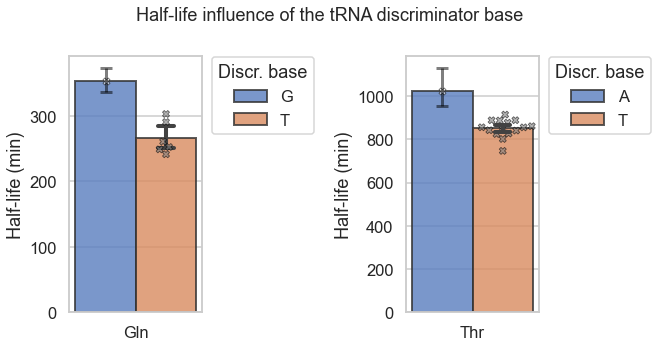

In [37]:
# Extract CI error bar data
# and align it to swarmplot jittered data:
def swarm_err(swarm, df):
    err = list()
    x = list()
    y = list()
    for c in swarm.collections:
        d = c.get_offsets()
        for dot in d:
            pmask = (df['hl'] == dot[1])
            if np.any(pmask):
                ci = df.loc[pmask, ['hl_ci_l', 'hl_ci_u']].values[0]
                ci = np.abs(ci - dot[1])
                err.append([[ci[0]], [ci[1]]])
                x.append(dot[0])
                y.append(dot[1])
    
    err = np.array(err)
    err = err.T[0]
    return(err, x, y)

# Selected either Gln or Thr amino acid:
mGln = (one_species_tab['amino_acid'] == 'Gln') 
mThr = (one_species_tab['amino_acid'] == 'Thr')
nonT = (one_species_tab['discr_base'] != 'T')

# Plot side by side:
with sns.axes_style("whitegrid"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9.5, 5))

    g1 = sns.barplot(ax=ax1, data=one_species_tab[mGln], x='amino_acid', y='hl', \
                     hue='discr_base', \
                     capsize=0.1, edgecolor=".2", linewidth=2, alpha=0.8, \
                     zorder=1)
    g1 = sns.swarmplot(ax=ax1, data=one_species_tab[mGln], x='amino_acid', y='hl', \
                       hue='discr_base', dodge=True, \
                       palette='light:grey', alpha=0.6, edgecolor='black', linewidth=0.8, \
                       size=7, marker="X", legend=False, \
                       zorder=2)
    sns.move_legend(g1, "upper left", bbox_to_anchor=(1.01, 1.03), ncol=1, title='Discr. base')
    g1.set(xlabel='', ylabel='Half-life (min)')
    
    err, x, y = swarm_err(g1, one_species_tab[mGln&nonT])
    ax1.errorbar(x, y, yerr=err, fmt='none', capsize=6, zorder=30, \
                 ecolor='black', elinewidth=3, capthick=3, alpha=0.5)

    g2 = sns.barplot(ax=ax2, data=one_species_tab[mThr], x='amino_acid', y='hl', \
                     hue='discr_base', \
                     capsize=0.1, edgecolor=".2", linewidth=2, alpha=0.8, \
                     zorder=1)
    g2 = sns.swarmplot(ax=ax2, data=one_species_tab[mThr], x='amino_acid', y='hl', \
                       hue='discr_base', dodge=True, \
                       palette='light:grey', alpha=0.6, edgecolor='black', linewidth=0.8, \
                       size=7, marker="X", legend=False, \
                       zorder=1)
    sns.move_legend(g2, "upper left", bbox_to_anchor=(1.01, 1.03), ncol=1, title='Discr. base')
    g2.set(xlabel='', ylabel='Half-life (min)')

    err, x, y = swarm_err(g2, one_species_tab[mThr&nonT])
    ax2.errorbar(x, y, yerr=err, fmt='none', capsize=6, zorder=30, \
                 ecolor='black', elinewidth=3, capthick=3, alpha=0.5)

fig.suptitle('Half-life influence of the tRNA discriminator base', size=18)
fig.tight_layout()
fig.savefig('data/plotting_pub/half-life_disc-base.pdf', bbox_inches='tight')